# Yolo

## Загружаем данные

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
ZIP_PATH = "drive/MyDrive/aiweek_exponenta/steelvision/archive.zip"
WORK_DIR = "/content/neu_det_project"

import os, zipfile

os.makedirs(WORK_DIR, exist_ok=True)

with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
    zip_ref.extractall(WORK_DIR)

print("Содержимое WORK_DIR:", os.listdir(WORK_DIR))

Содержимое WORK_DIR: ['NEU-DET']


## Задаём пути и классы

In [ ]:
NEU_ROOT = os.path.join(WORK_DIR, "NEU-DET")

print("NEU_ROOT:", NEU_ROOT)
print("train:", os.listdir(os.path.join(NEU_ROOT, "train")))
print("val:", os.listdir(os.path.join(NEU_ROOT, "validation")))

NEU_ROOT: /content/neu_det_project/NEU-DET
train: ['annotations', 'images']
val: ['annotations', 'images']


Карта классов

In [ ]:
classes = {
    "crazing": 0,
    "inclusion": 1,
    "patches": 2,
    "pitted_surface": 3,
    "rolled-in_scale": 4,
    "scratches": 5,
}

## Готовим структуру под YOLO

In [ ]:
YOLO_ROOT = os.path.join(WORK_DIR, "neu_det_yolo")
IMG_TRAIN_DIR = os.path.join(YOLO_ROOT, "images", "train")
IMG_VAL_DIR   = os.path.join(YOLO_ROOT, "images", "val")
LBL_TRAIN_DIR = os.path.join(YOLO_ROOT, "labels", "train")
LBL_VAL_DIR   = os.path.join(YOLO_ROOT, "labels", "val")

for d in [YOLO_ROOT, IMG_TRAIN_DIR, IMG_VAL_DIR, LBL_TRAIN_DIR, LBL_VAL_DIR]:
    os.makedirs(d, exist_ok=True)

YOLO_ROOT

'/content/neu_det_project/neu_det_yolo'

## Конвертация VOC XML → YOLO TXT

In [ ]:
import xml.etree.ElementTree as ET
from glob import glob
import shutil

def convert_voc_xml_to_yolo_txt(
    xml_path: str,
    images_root: str,
    labels_root: str,
    split: str = "train"
):
    """
    xml_path: путь к .xml
    images_root: корень с папками классов (crazing, inclusion, ...)
    labels_root: куда писать .txt
    split: 'train' или 'val' (для инфы)
    """
    tree = ET.parse(xml_path)
    root = tree.getroot()

    filename = root.find("filename").text  # например "crazing_1.jpg"

    # Найдем, в какой подпапке лежит изображение (crazing / inclusion / ...)
    # Можно просто пройтись по всем подпапкам и проверить наличие файла.
    img_path = None
    for cls_dir in os.listdir(images_root):
        candidate = os.path.join(images_root, cls_dir, filename)
        if os.path.exists(candidate):
            img_path = candidate
            break

    if img_path is None:
        print(f"[{split}] Не нашёл изображение для {xml_path}")
        return

    # Скопируем картинку в нужную папку YOLO (train или val)
    if split == "train":
        target_img_path = os.path.join(IMG_TRAIN_DIR, filename)
    else:
        target_img_path = os.path.join(IMG_VAL_DIR, filename)

    shutil.copy2(img_path, target_img_path)

    # Размер изображения
    size = root.find("size")
    img_w = float(size.find("width").text)
    img_h = float(size.find("height").text)

    # Собираем разметку
    yolo_lines = []

    for obj in root.findall("object"):
        name = obj.find("name").text  # имя класса, например "crazing"
        if name not in classes:
            print(f"Неизвестный класс {name} в {xml_path}")
            continue

        cls_id = classes[name]
        bbox = obj.find("bndbox")
        xmin = float(bbox.find("xmin").text)
        ymin = float(bbox.find("ymin").text)
        xmax = float(bbox.find("xmax").text)
        ymax = float(bbox.find("ymax").text)

        # Подстрахуемся, чтобы координаты не выходили за границы
        xmin = max(0, min(xmin, img_w - 1))
        ymin = max(0, min(ymin, img_h - 1))
        xmax = max(1, min(xmax, img_w))
        ymax = max(1, min(ymax, img_h))

        # Переводим в формат YOLO [0,1]
        x_center = (xmin + xmax) / 2.0 / img_w
        y_center = (ymin + ymax) / 2.0 / img_h
        w = (xmax - xmin) / img_w
        h = (ymax - ymin) / img_h

        yolo_lines.append(f"{cls_id} {x_center:.6f} {y_center:.6f} {w:.6f} {h:.6f}")

    # Пишем .txt рядом с картинкой в labels/train или labels/val
    if split == "train":
        label_path = os.path.join(LBL_TRAIN_DIR, filename.replace(".jpg", ".txt"))
    else:
        label_path = os.path.join(LBL_VAL_DIR, filename.replace(".jpg", ".txt"))

    with open(label_path, "w") as f:
        f.write("\n".join(yolo_lines))


# Запускаем конвертацию для train и validation
train_ann_dir = os.path.join(NEU_ROOT, "train", "annotations")
val_ann_dir   = os.path.join(NEU_ROOT, "validation", "annotations")
train_img_root = os.path.join(NEU_ROOT, "train", "images")
val_img_root   = os.path.join(NEU_ROOT, "validation", "images")

train_xmls = glob(os.path.join(train_ann_dir, "*.xml"))
val_xmls   = glob(os.path.join(val_ann_dir, "*.xml"))

len(train_xmls), len(val_xmls)

(1439, 361)

In [ ]:
for xml in train_xmls:
    convert_voc_xml_to_yolo_txt(xml, train_img_root, LBL_TRAIN_DIR, split="train")

for xml in val_xmls:
    convert_voc_xml_to_yolo_txt(xml, val_img_root, LBL_VAL_DIR, split="val")

print("Готово!")
print("Примеры файлов в images/train:", len(os.listdir(IMG_TRAIN_DIR)))
print("Примеры файлов в labels/train:", len(os.listdir(LBL_TRAIN_DIR)))

[train] Не нашёл изображение для /content/neu_det_project/NEU-DET/train/annotations/patches_157.xml
[train] Не нашёл изображение для /content/neu_det_project/NEU-DET/train/annotations/pitted_surface_70.xml
[train] Не нашёл изображение для /content/neu_det_project/NEU-DET/train/annotations/pitted_surface_61.xml
[train] Не нашёл изображение для /content/neu_det_project/NEU-DET/train/annotations/pitted_surface_188.xml
[train] Не нашёл изображение для /content/neu_det_project/NEU-DET/train/annotations/patches_26.xml
[train] Не нашёл изображение для /content/neu_det_project/NEU-DET/train/annotations/patches_106.xml
[train] Не нашёл изображение для /content/neu_det_project/NEU-DET/train/annotations/pitted_surface_185.xml
[train] Не нашёл изображение для /content/neu_det_project/NEU-DET/train/annotations/pitted_surface_109.xml
[train] Не нашёл изображение для /content/neu_det_project/NEU-DET/train/annotations/patches_169.xml
[train] Не нашёл изображение для /content/neu_det_project/NEU-DET/tr

In [ ]:
sample_lbl = os.listdir(LBL_TRAIN_DIR)[0]
print("Пример разметки:", sample_lbl)
with open(os.path.join(LBL_TRAIN_DIR, sample_lbl), "r") as f:
    print(f.read())

Пример разметки: pitted_surface_173.txt
3 0.510000 0.457500 0.980000 0.905000
2 0.612500 0.937500 0.245000 0.115000
2 0.870000 0.887500 0.220000 0.225000


## Создаём data.yaml для YOLO

In [ ]:
data_yaml_path = os.path.join(YOLO_ROOT, "data.yaml")
data_yaml_content = f"""
path: {YOLO_ROOT}
train: images/train
val: images/val

nc: 6
names:
  0: crazing
  1: inclusion
  2: patches
  3: pitted_surface
  4: rolled-in_scale
  5: scratches
"""

with open(data_yaml_path, "w") as f:
    f.write(data_yaml_content.strip())

print(open(data_yaml_path).read())


path: /content/neu_det_project/neu_det_yolo
train: images/train
val: images/val

nc: 6
names:
  0: crazing
  1: inclusion
  2: patches
  3: pitted_surface
  4: rolled-in_scale
  5: scratches


## Устанавливаем Ultralytics (YOLO)

In [ ]:
!pip install -q ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 50.0 MB/s eta 0:00:00


## Конфиг для разных моделей

In [ ]:
import os
import shutil
import pandas as pd
import matplotlib.pyplot as plt
from ultralytics import YOLO


MODELS_CONFIG = {
    # =====================
    # YOLOv8 baseline models
    # =====================
    "yolov8s": {
        "model_path": "yolov8s.pt",
        "project": "neu_det_yolov8s",
        "exp_name": "exp_yolov8s",
        "drive_dir": "/content/drive/MyDrive/aiweek_exponenta/steelvision/yolov8s",
    },
    "yolov8n": {
        "model_path": "yolov8n.pt",
        "project": "neu_det_yolov8n",
        "exp_name": "exp_yolov8n",
        "drive_dir": "/content/drive/MyDrive/aiweek_exponenta/steelvision/yolov8n",
    },

    # =====================
    # YOLO11 (Ultralytics 2024–2025)
    # =====================
    "yolo11s": {
        "model_path": "yolo11s.pt",
        "project": "neu_det_yolo11s",
        "exp_name": "exp_yolo11s",
        "drive_dir": "/content/drive/MyDrive/aiweek_exponenta/steelvision/yolo11s",
    },
    "yolo11n": {
        "model_path": "yolo11n.pt",
        "project": "neu_det_yolo11n",
        "exp_name": "exp_yolo11n",
        "drive_dir": "/content/drive/MyDrive/aiweek_exponenta/steelvision/yolo11n",
    },

    # Medium, Large variants
    "yolo11m": {
        "model_path": "yolo11m.pt",
        "project": "neu_det_yolo11m",
        "exp_name": "exp_yolo11m",
        "drive_dir": "/content/drive/MyDrive/aiweek_exponenta/steelvision/yolo11m",
    },
    "yolo11l": {
        "model_path": "yolo11l.pt",
        "project": "neu_det_yolo11l",
        "exp_name": "exp_yolo11l",
        "drive_dir": "/content/drive/MyDrive/aiweek_exponenta/steelvision/yolo11l",
    }
}


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## Проведение эксперимента

In [ ]:
def run_experiment(model_key, data_yaml_path, epochs=50, imgsz=640, batch=16, **train_kwargs):
    cfg = MODELS_CONFIG[model_key]
    print(f"=== Запуск эксперимента для модели: {model_key} ===")
    print(f"Модель: {cfg['model_path']}")
    print("Проект:", cfg["project"])
    print("Эксперимент:", cfg["exp_name"])
    print()

    # ----- 1. Загрузка модели -----
    model = YOLO(cfg["model_path"])

    # ----- 2. Обучение -----
    results = model.train(
        data=data_yaml_path,
        epochs=epochs,
        imgsz=imgsz,
        batch=batch,
        project=cfg["project"],
        name=cfg["exp_name"],
        exist_ok=True,
        **train_kwargs
    )

    # Папка эксперимента в /content
    exp_dir = os.path.join("/content", cfg["project"], cfg["exp_name"])
    print("Папка эксперимента:", exp_dir)

    # ----- 3. Экспорт модели в ONNX -----
    print("\nЭкспорт в ONNX...")
    model.export(
        format="onnx",
        dynamic=True,
        simplify=True
    )
    print("✅ Экспорт в ONNX завершён")

    # ----- 4. Загрузка метрик -----
    csv_path = os.path.join(exp_dir, "results.csv")
    df = pd.read_csv(csv_path)

    # ----- 5. Отрисовка графиков -----

    # ---- mAP@0.5 ----
    plt.figure(figsize=(8, 5))
    plt.plot(df["epoch"], df["metrics/mAP50(B)"])
    plt.xlabel("Epoch")
    plt.ylabel("mAP@0.5")
    plt.title(f"Динамика mAP@0.5 по эпохам ({model_key})")
    plt.grid(True)
    plt.show()

    map50_path = os.path.join(exp_dir, "map50.png")
    plt.savefig(map50_path)
    print("📈 Сохранён график:", map50_path)

    # ---- mAP@0.5:0.95 ----
    plt.figure(figsize=(8, 5))
    plt.plot(df["epoch"], df["metrics/mAP50-95(B)"])
    plt.xlabel("Epoch")
    plt.ylabel("mAP@0.5:0.95")
    plt.title(f"Динамика mAP@0.5:0.95 по эпохам ({model_key})")
    plt.grid(True)
    plt.show()

    map5095_path = os.path.join(exp_dir, "map50_95.png")
    plt.savefig(map5095_path)
    print("📈 Сохранён график:", map5095_path)

    # ----- 6. Финальные значения mAP -----
    last = df.iloc[-1]
    final_map_table = {
        "Модель": model_key,
        "Итоговая эпоха": int(last["epoch"]),
        "mAP@0.5": round(float(last["metrics/mAP50(B)"]), 4),
        "mAP@0.5:0.95": round(float(last["metrics/mAP50-95(B)"]), 4),
    }

    print("\n📊 Финальные метрики:")
    print(final_map_table)

    # ----- 7. Копируем всё на Google Drive -----
    drive_exp_dir = os.path.join(cfg["drive_dir"], cfg["exp_name"])
    os.makedirs(cfg["drive_dir"], exist_ok=True)

    if os.path.exists(drive_exp_dir):
        shutil.rmtree(drive_exp_dir)

    shutil.copytree(exp_dir, drive_exp_dir)
    print("📂 Папка эксперимента скопирована на диск:")
    print(drive_exp_dir)

    # ----- 8. Тестовый инференс -----
    best_model_path = os.path.join(drive_exp_dir, "weights", "best.pt")
    print("\nЗагружаем лучшую модель:", best_model_path)

    best_model = YOLO(best_model_path)

    test_img_path = os.path.join(IMG_VAL_DIR, os.listdir(IMG_VAL_DIR)[0])
    print("Тестируем на:", test_img_path)

    infer_results = best_model(test_img_path, conf=0.25, save=True)
    print("✅ Инференс выполнен, результат сохранён в runs/detect/predict*")

    return {
        "config": cfg,
        "final_metrics": final_map_table,
        "exp_dir": exp_dir,
        "drive_exp_dir": drive_exp_dir,
    }

### YOLOv8s

=== Запуск эксперимента для модели: yolov8s ===
Модель: yolov8s.pt
Проект: neu_det_yolov8s, эксперимент: exp_yolov8s

Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/neu_det_project/neu_det_yolo/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=ex

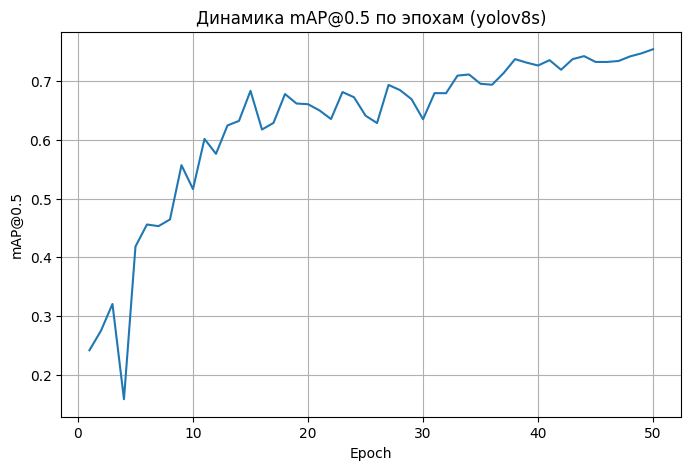

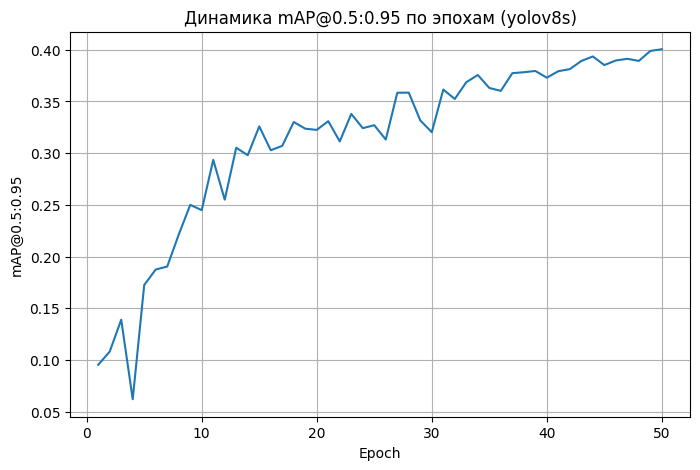


📊 Финальные метрики:
{'Модель': 'yolov8s', 'Итоговая эпоха': 50, 'mAP@0.5': 0.7541, 'mAP@0.5:0.95': 0.4005}

Загружаем лучшую модель для инференса:
/content/drive/MyDrive/aiweek_exponenta/steelvision/yolov8s/exp_yolov8s/weights/best.pt
Тестируем на: /content/neu_det_project/neu_det_yolo/images/val/rolled-in_scale_255.jpg

image 1/1 /content/neu_det_project/neu_det_yolo/images/val/rolled-in_scale_255.jpg: 640x640 3 rolled-in_scales, 16.2ms
Speed: 2.1ms preprocess, 16.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/runs/detect/predict
✅ Инференс выполнен, результат сохранён в runs/detect/predict*


In [ ]:
run_experiment(
    "yolov8s",
    data_yaml_path,
    epochs=50,
    imgsz=640,
    batch=16
)

### YOLOv8n

=== Запуск эксперимента для модели: yolov8n ===
Модель: yolov8n.pt
Проект: neu_det_yolov8n, эксперимент: exp_yolov8n

Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/neu_det_project/neu_det_yolo/data.yaml, degrees=0.0, deterministic=True, device=, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=exp_yo

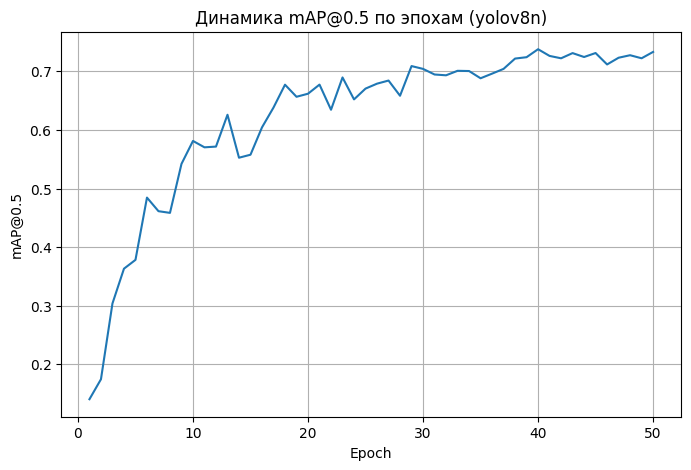

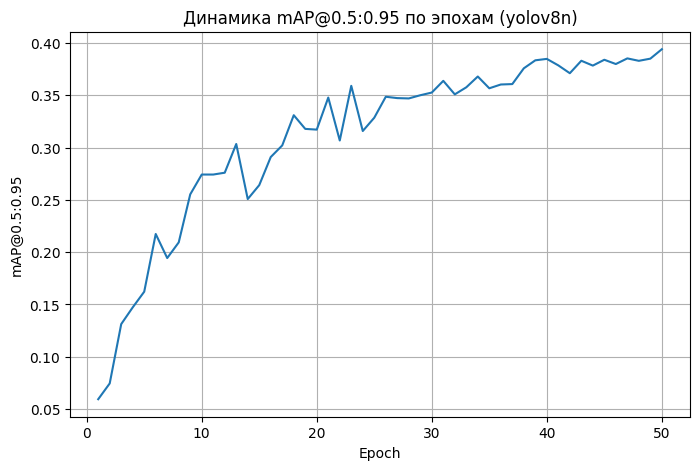


📊 Финальные метрики:
{'Модель': 'yolov8n', 'Итоговая эпоха': 50, 'mAP@0.5': 0.7332, 'mAP@0.5:0.95': 0.3942}

Загружаем лучшую модель для инференса:
/content/drive/MyDrive/aiweek_exponenta/steelvision/yolov8n/exp_yolov8n/weights/best.pt
Тестируем на: /content/neu_det_project/neu_det_yolo/images/val/rolled-in_scale_255.jpg

image 1/1 /content/neu_det_project/neu_det_yolo/images/val/rolled-in_scale_255.jpg: 640x640 5 rolled-in_scales, 7.1ms
Speed: 3.0ms preprocess, 7.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/runs/detect/predict2
✅ Инференс выполнен, результат сохранён в runs/detect/predict*


In [ ]:
run_experiment(
    "yolov8n",
    data_yaml_path,
    epochs=50,
    imgsz=640,
    batch=16
)

### YOLO11s

=== Запуск эксперимента для модели: yolo11s ===
Модель: yolo11s.pt
Проект: neu_det_yolo11s
Эксперимент: exp_yolo11s

Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/content/neu_det_project/neu_det_yolo/data.yaml, degrees=0.0, deterministic=True, device=, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0008, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=exp_yo

Traceback (most recent call last):
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 259, in _feed
    reader_close()
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 178, in close
    self._close()
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 377, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       5/60      5.33G      1.731      1.952      1.758          4        640: 100% ━━━━━━━━━━━━ 80/80 3.2it/s 24.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 3.6it/s 3.4s
                   all        360        854      0.272      0.512       0.37      0.165

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       6/60      5.33G      1.679       1.83      1.718          4        640: 100% ━━━━━━━━━━━━ 80/80 3.2it/s 25.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 4.0it/s 3.0s
                   all        360        854      0.493      0.359      0.324      0.124

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       7/60      5.33G      1.649      1.772      1.685          3        640: 100% ━━━━━━━━━━━━ 

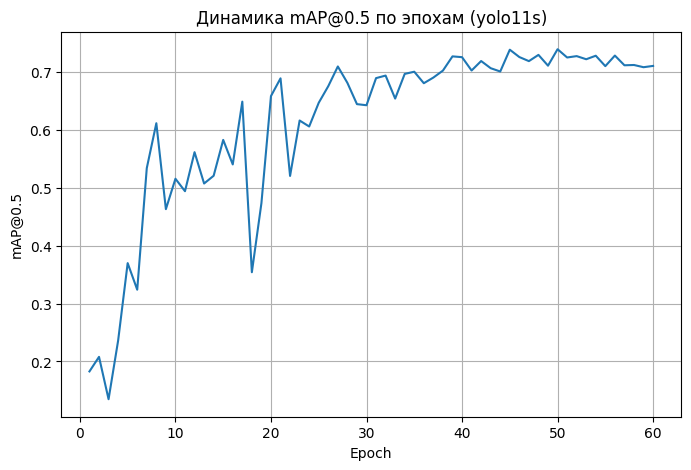

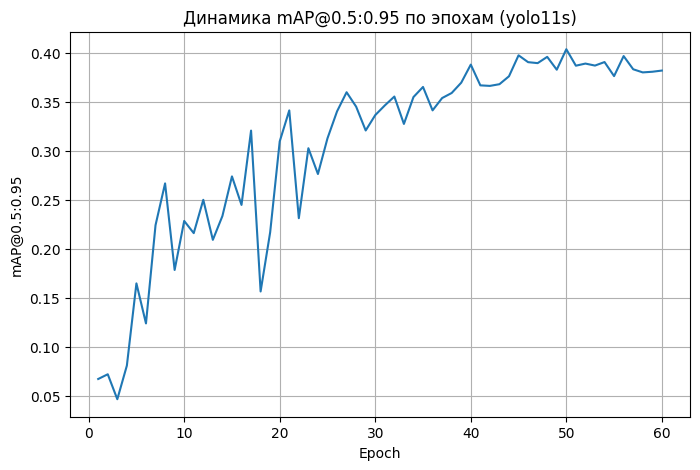


📊 Финальные метрики:
{'Модель': 'yolo11s', 'Итоговая эпоха': 60, 'mAP@0.5': 0.7103, 'mAP@0.5:0.95': 0.382}

Загружаем лучшую модель для инференса:
/content/drive/MyDrive/aiweek_exponenta/steelvision/yolo11s/exp_yolo11s/weights/best.pt
Тестируем на: /content/neu_det_project/neu_det_yolo/images/val/rolled-in_scale_255.jpg

image 1/1 /content/neu_det_project/neu_det_yolo/images/val/rolled-in_scale_255.jpg: 640x640 2 rolled-in_scales, 15.3ms
Speed: 2.2ms preprocess, 15.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/runs/detect/predict3
✅ Инференс выполнен, результат сохранён в runs/detect/predict*


{'config': {'model_path': 'yolo11s.pt',
  'project': 'neu_det_yolo11s',
  'exp_name': 'exp_yolo11s',
  'drive_dir': '/content/drive/MyDrive/aiweek_exponenta/steelvision/yolo11s'},
 'final_metrics': {'Модель': 'yolo11s',
  'Итоговая эпоха': 60,
  'mAP@0.5': 0.7103,
  'mAP@0.5:0.95': 0.382},
 'exp_dir': '/content/neu_det_yolo11s/exp_yolo11s',
 'drive_exp_dir': '/content/drive/MyDrive/aiweek_exponenta/steelvision/yolo11s/exp_yolo11s'}

In [ ]:
run_experiment(
    "yolo11s",
    data_yaml_path,
    epochs=60,
    imgsz=640,
    batch=16,
    lr0=8e-4,
    cos_lr=True,
    patience=25
)

### YOLO11n

=== Запуск эксперимента для модели: yolo11n ===
Модель: yolo11n.pt
Проект: neu_det_yolo11n
Эксперимент: exp_yolo11n

Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/content/neu_det_project/neu_det_yolo/data.yaml, degrees=0.0, deterministic=True, device=, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0008, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=exp_yo

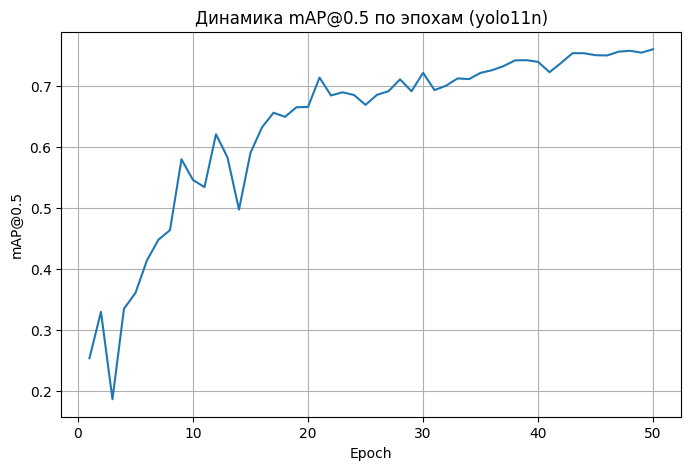

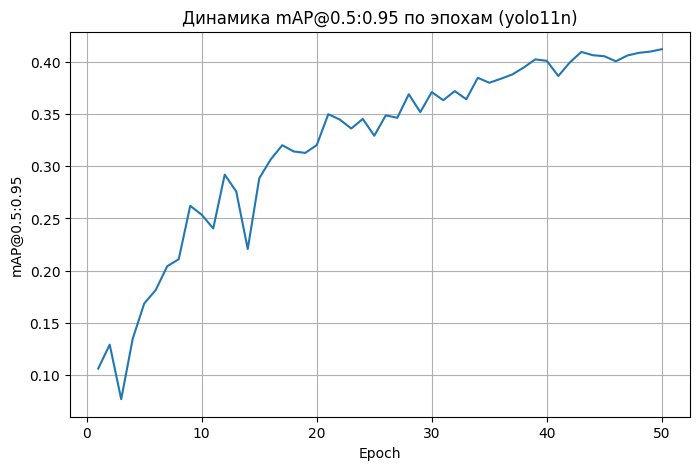


📊 Финальные метрики:
{'Модель': 'yolo11n', 'Итоговая эпоха': 50, 'mAP@0.5': 0.7603, 'mAP@0.5:0.95': 0.4122}

Загружаем лучшую модель для инференса:
/content/drive/MyDrive/aiweek_exponenta/steelvision/yolo11n/exp_yolo11n/weights/best.pt
Тестируем на: /content/neu_det_project/neu_det_yolo/images/val/rolled-in_scale_255.jpg

image 1/1 /content/neu_det_project/neu_det_yolo/images/val/rolled-in_scale_255.jpg: 640x640 5 rolled-in_scales, 9.6ms
Speed: 3.0ms preprocess, 9.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/runs/detect/predict4
✅ Инференс выполнен, результат сохранён в runs/detect/predict*


{'config': {'model_path': 'yolo11n.pt',
  'project': 'neu_det_yolo11n',
  'exp_name': 'exp_yolo11n',
  'drive_dir': '/content/drive/MyDrive/aiweek_exponenta/steelvision/yolo11n'},
 'final_metrics': {'Модель': 'yolo11n',
  'Итоговая эпоха': 50,
  'mAP@0.5': 0.7603,
  'mAP@0.5:0.95': 0.4122},
 'exp_dir': '/content/neu_det_yolo11n/exp_yolo11n',
 'drive_exp_dir': '/content/drive/MyDrive/aiweek_exponenta/steelvision/yolo11n/exp_yolo11n'}

In [ ]:
run_experiment(
    "yolo11n",
    data_yaml_path,
    epochs=50,
    imgsz=640,
    batch=16,
    lr0=8e-4,
    cos_lr=True
)

### YOLO11m

=== Запуск эксперимента для модели: yolo11m ===
Модель: yolo11m.pt
Проект: neu_det_yolo11m
Эксперимент: exp_yolo11m

Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/content/neu_det_project/neu_det_yolo/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=70, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0007, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=ex

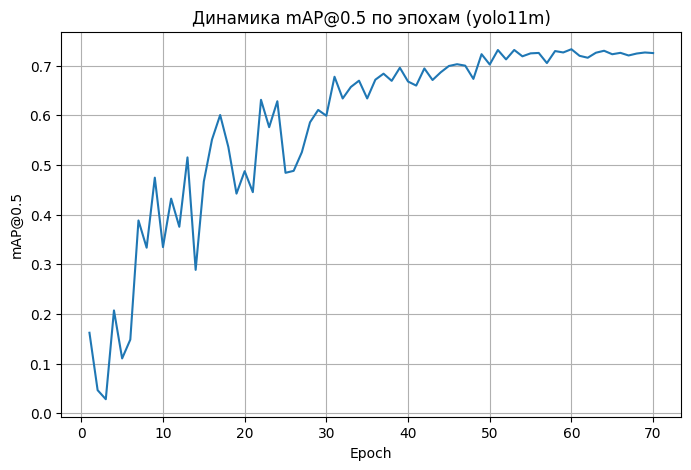

📈 Сохранён график: /content/neu_det_yolo11m/exp_yolo11m/map50.png


<Figure size 640x480 with 0 Axes>

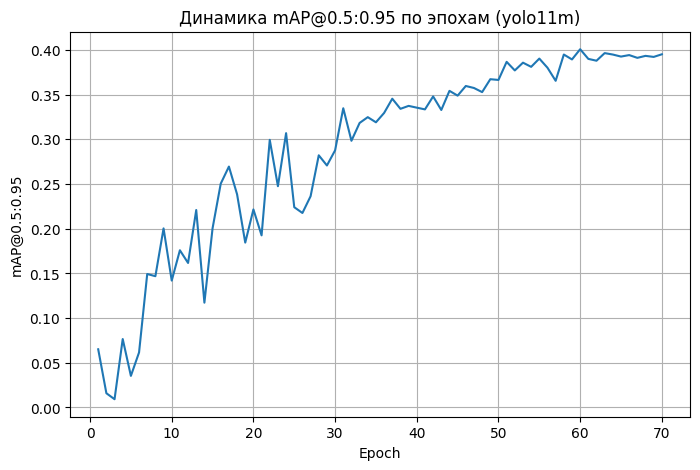

📈 Сохранён график: /content/neu_det_yolo11m/exp_yolo11m/map50_95.png

📊 Финальные метрики:
{'Модель': 'yolo11m', 'Итоговая эпоха': 70, 'mAP@0.5': 0.7255, 'mAP@0.5:0.95': 0.3951}
📂 Папка эксперимента скопирована на диск:
/content/drive/MyDrive/aiweek_exponenta/steelvision/yolo11m/exp_yolo11m

Загружаем лучшую модель: /content/drive/MyDrive/aiweek_exponenta/steelvision/yolo11m/exp_yolo11m/weights/best.pt
Тестируем на: /content/neu_det_project/neu_det_yolo/images/val/rolled-in_scale_255.jpg

image 1/1 /content/neu_det_project/neu_det_yolo/images/val/rolled-in_scale_255.jpg: 640x640 3 rolled-in_scales, 36.9ms
Speed: 2.5ms preprocess, 36.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/runs/detect/predict
✅ Инференс выполнен, результат сохранён в runs/detect/predict*


{'config': {'model_path': 'yolo11m.pt',
  'project': 'neu_det_yolo11m',
  'exp_name': 'exp_yolo11m',
  'drive_dir': '/content/drive/MyDrive/aiweek_exponenta/steelvision/yolo11m'},
 'final_metrics': {'Модель': 'yolo11m',
  'Итоговая эпоха': 70,
  'mAP@0.5': 0.7255,
  'mAP@0.5:0.95': 0.3951},
 'exp_dir': '/content/neu_det_yolo11m/exp_yolo11m',
 'drive_exp_dir': '/content/drive/MyDrive/aiweek_exponenta/steelvision/yolo11m/exp_yolo11m'}

<Figure size 640x480 with 0 Axes>

In [ ]:
run_experiment(
    "yolo11m",
    data_yaml_path,
    epochs=70,
    imgsz=640,
    batch=16,
    lr0=7e-4,
    cos_lr=True,
    patience=20
)

### YOLO11l

In [ ]:
run_experiment(
    "yolo11l",
    data_yaml_path,
    epochs=80,
    imgsz=640,
    batch=12,
    lr0=5e-4,
    cos_lr=True,
    patience=20
)

=== Запуск эксперимента для модели: yolo11l ===
Модель: yolo11l.pt
Проект: neu_det_yolo11l
Эксперимент: exp_yolo11l

Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=12, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/content/neu_det_project/neu_det_yolo/data.yaml, degrees=0.0, deterministic=True, device=, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=80, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0005, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11l.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=exp_yo

## Итоговое сравнение моделей

### Задаём конфиг для моделей

In [ ]:
summary_configs = [
    {
        "name": "yolov8s",
        "exp_dir": "/content/drive/MyDrive/aiweek_exponenta/steelvision/yolov8s/exp_yolov8s",
    },
    {
        "name": "yolov8n",
        "exp_dir": "/content/drive/MyDrive/aiweek_exponenta/steelvision/yolov8n/exp_yolov8n",
    },
    {
        "name": "yolo11s",
        "exp_dir": "/content/drive/MyDrive/aiweek_exponenta/steelvision/yolo11s/exp_yolo11s",
    },
    {
        "name": "yolo11n",
        "exp_dir": "/content/drive/MyDrive/aiweek_exponenta/steelvision/yolo11n/exp_yolo11n",
    },
    {
        "name": "yolo11m",
        "exp_dir": "/content/drive/MyDrive/aiweek_exponenta/steelvision/yolo11m/exp_yolo11m",
    },
    {
        "name": "yolo11l",
        "exp_dir": "/content/drive/MyDrive/aiweek_exponenta/steelvision/yolo11l/exp_yolo11l",
    }
]

### Собираем метрики по каждой модели

In [ ]:
rows = []

for cfg in summary_configs:
    name = cfg["name"]
    exp_dir = cfg["exp_dir"]
    csv_path = os.path.join(exp_dir, "results.csv")
    weights_path = os.path.join(exp_dir, "weights", "best.pt")

    if not os.path.exists(csv_path):
        print(f"⚠️ Для {name} не найден results.csv по пути {csv_path}, пропускаю")
        continue
    if not os.path.exists(weights_path):
        print(f"⚠️ Для {name} не найден weights/best.pt по пути {weights_path}, пропускаю")
        continue

    # ---- 2.1. Метрики из results.csv ----
    df = pd.read_csv(csv_path)
    last = df.iloc[-1]

    epoch = int(last["epoch"])
    map50 = float(last["metrics/mAP50(B)"])
    map50_95 = float(last["metrics/mAP50-95(B)"])

    # ---- 2.2. Информация о модели ----
    model = YOLO(weights_path)

    # Количество параметров
    params = sum(p.numel() for p in model.model.parameters())
    params_m = params / 1e6

    # Размер файла весов
    weights_mb = os.path.getsize(weights_path) / (1024 ** 2)

    rows.append({
        "model": name,
        "epoch": epoch,
        "mAP@0.5": round(map50, 4),
        "mAP@0.5:0.95": round(map50_95, 4),
        "params_M": round(params_m, 2),
        "weights_MB": round(weights_mb, 2),
        "exp_dir": exp_dir,
    })

summary_df = pd.DataFrame(rows)
summary_df

,model,epoch,mAP@0.5,mAP@0.5:0.95,params_M,weights_MB,exp_dir
0,yolov8s,50,0.7541,0.4005,11.14,21.48,/content/drive/MyDrive/aiweek_exponenta/steelv...
1,yolov8n,50,0.7332,0.3942,3.01,5.96,/content/drive/MyDrive/aiweek_exponenta/steelv...
2,yolo11s,60,0.7103,0.3820,9.43,18.29,/content/drive/MyDrive/aiweek_exponenta/steelv...
3,yolo11n,50,0.7603,0.4122,2.59,5.22,/content/drive/MyDrive/aiweek_exponenta/steelv...
4,yolo11m,70,0.7255,0.3951,20.06,38.65,/content/drive/MyDrive/aiweek_exponenta/steelv...
5,yolo11l,80,0.7659,0.4121,25.32,48.83,/content/drive/MyDrive/aiweek_exponenta/steelv...


### Отсортируем модели по качеству

In [ ]:
summary_sorted = summary_df.sort_values(by="mAP@0.5", ascending=False).reset_index(drop=True)
summary_sorted

,model,epoch,mAP@0.5,mAP@0.5:0.95,params_M,weights_MB,exp_dir
0,yolo11l,80,0.7659,0.4121,25.32,48.83,/content/drive/MyDrive/aiweek_exponenta/steelv...
1,yolo11n,50,0.7603,0.4122,2.59,5.22,/content/drive/MyDrive/aiweek_exponenta/steelv...
2,yolov8s,50,0.7541,0.4005,11.14,21.48,/content/drive/MyDrive/aiweek_exponenta/steelv...
3,yolov8n,50,0.7332,0.3942,3.01,5.96,/content/drive/MyDrive/aiweek_exponenta/steelv...
4,yolo11m,70,0.7255,0.3951,20.06,38.65,/content/drive/MyDrive/aiweek_exponenta/steelv...
5,yolo11s,60,0.7103,0.3820,9.43,18.29,/content/drive/MyDrive/aiweek_exponenta/steelv...


In [ ]:
best_row = summary_sorted.iloc[0].to_dict()
best_row

{'model': 'yolo11l',
 'epoch': 80,
 'mAP@0.5': 0.7659,
 'mAP@0.5:0.95': 0.4121,
 'params_M': 25.32,
 'weights_MB': 48.83,
 'exp_dir': '/content/drive/MyDrive/aiweek_exponenta/steelvision/yolo11l/exp_yolo11l'}